# SYDE 411 Optimization Project

## Team members:

- Sammy Robens-Paradise, 20709541
- Wassim Maj , 21048694
- Tim He, 20779429
- <full_name> , <student_number>


## Import Dependencies

Dependencies are `numpy` `matplotlib` and `scipy`. You can install both dependencies (assuming you have `Python >= 3` ) using pip:

- `pip install numpy`
- `pip install matplotlib`
- `pip install scipy`
- `pip install pulp`


In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pulp

np.random.seed(18945)
# Some formating options
%config InlineBackend.figure_formats = ['svg']

## Problem Definition

The problem will be formulated as follows: Given 1 bus with a maximum capacity, $m$, we want to minimize the distance that the bus has to travel to $n$ locations (nodes) to pick up a total number of $P$ Our objective function is to minimize the total distance travelled, which is in turn a function of the distance to each location and the whether the locaction is connected to another location. This is commonly referred to as the **Vehicle Routing Problem**



## Problem to Minimize

For **K** vehicles where $K=\{1,2,...,k\}, k \gt 0$:

$G=(V,E)$ is a graph of the location and routes of the vehicles

$V=\{0,1,...n\}$ is a collection of nodes (locations) where $n_0$ is the start and end location for $K$ vehicles

$E$ is the set of edges $e_{ij} = (i,j)$ connecting each node

$c_{ij}$ is the cost (distance) between $i$ and $j$

### Variables:

$x_{ij}=
\begin{cases}
1: \text{the path goes from city i to j}\\
0: \text{otherwise}
\end{cases}$

$u_i - u_j + C*x_{ij} \leq C - d_j, C = N/K$
$\begin{cases}
u_i: \text{order that site i is visited}\\
d_j: \text{the cost to visit city j}, 0 \leq u_i \leq C - d_j, \forall i \in V \setminus \{0\}
\end{cases}$

### Objective Function:

(1) - $min\sum_{i=0}^{n}\sum_{j\neq{i}, j=0}^{n}{c_{ij}}{x_{ij}}$
$\begin{cases}
c_{ij}: \text{distance from city i to city j}\\
x_{ij}: \text{whether there's a path between i and j}
\end{cases}$

### With the following constraints:

(2) - $\sum_{i\in{V}}{x_{ij} = 1}, \forall j \in V \setminus \{0\}$

(3) - $\sum_{j\in{V}}{x_{ij} = 1}, \forall i \in V \setminus \{0\}$

(4) - $\sum_{i\in{V}}{x_{i0} = K}$

(5) - $\sum_{j\in{V}}{x_{0j} = K}$

### Where
- (1) is the _objective function_ 
- (2,3) constrains the (1)such that a location that is not the start and end location can only be visited by one vehicle
- (4) constrains (1) such that the start location is the first and that every vehicle starts there.
- (5) constrains (1) problem such the last location is the same as the first location and every vechicle must end there.


## Define Default Problem Constants

In [82]:
# CONSTANTS

# delare constants to seed the data model
# the number of locations EXCLUDING the central starting and ending location
NUM_LOCATIONS = 14
NUM_VEHICLES = 2
GRID_SIZE = {"x": 1000, "y": 1000}
SEED = 18945
CENTRAL_LOCATION="Central Location"


# possible distances are
# - "manhattan"
# - "euclidean"
# - "chebyshev"
DISTANCE_METHOD = "manhattan"

## Create Help Methods

In [83]:
def distance(
    p1,
    p2,
    method="manhattan",
):
    """Calculate the distance between two 2D points

    Parameters:
        p1 (ndarray) length == 2
        p2 (ndarray) length == 2
        method (string) "manhattan" | "euclidean" | "chebyshev"

    Returns:
        d (int) 2D distance between p1 and p2
    """
    # make sure that the distance is between only a coordinate
    assert len(p1) == len(p2) == 2
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]

    d = 0
    # if the locations are the same then we can automatically say the distance is 0
    if x1 == x2 and y1 == y2:
        return d
    if method == "manhattan":
        d = np.absolute(x1 - x2) + np.absolute(y1 - y2)
    elif method == "euclidean":
        d = np.sqrt(np.power(x2 - x1, 2) + np.power(y2 - y1, 2))
    elif method == "chebyshev":
        d = np.max([np.absolute(x2 - x1), np.absolute(y2 - y1)])
    return d


def generate_data(
    num_locations=NUM_LOCATIONS,
    grid_size=GRID_SIZE,
    seed=None,
    distance_method="manhattan",
):
    """Generate the data for a given problem

    Args:
        num_locations (_int_, optional) Defaults to NUM_LOCATIONS.
        grid_size (_dict_, optional). Defaults to GRID_SIZE.
        seed (_int_, optional). Defaults to None.
        distance_method (str, optional). Defaults to "manhattan".

    Returns:
        locations: array of locations
        distances: n by n matrix of distances to each location from each location
        annotations: array of strings annotated coordinates of each location
    """
    # seed our data so that we have reproducible data
    if seed != None:
        np.random.seed(seed)
    locations = []
    annotations = []
    central_location_coord = [0, 0]
    # the central location is taken to be (0,0)
    locations.append(central_location_coord)
    annotations.append(CENTRAL_LOCATION)
    for _ in range(num_locations):
        x_coord = np.random.randint(-1 * grid_size["x"] / 2, grid_size["x"] / 2)
        y_coord = np.random.randint(-1 * grid_size["y"] / 2, grid_size["y"] / 2)
        node_coord = [x_coord, y_coord]
        label = "(" + str(x_coord) + "," + str(y_coord) + ")"
        locations.append(node_coord)
        annotations.append(label)
    locations = np.array(locations)
    distances = []
    for c1 in locations:
        local_distance = []
        for c2 in locations:
            d = distance(c1, c2, method=distance_method)
            local_distance.append(d)
        distances.append(local_distance)

    return locations, np.array(distances), annotations


def _validate_distances_(distances):
    assert (
        distances.shape[0] == distances.shape[1] == NUM_LOCATIONS + 1
    ), "Expected Distance matrix to be square and to equal NUM_LOCATIONS + 1"
    for i, _ in enumerate(distances):
        assert distances[i][i] == 0, "Distance diagonals cannot be non-zero"


def generate_lp_problem(title="cap_vehicle_routing_roblem"):
    """Generates a PuLP problem

    Args:
        title (str, optional): _description_. Defaults to "cap_vehicle_routing_roblem".

    Returns:
        PuLP Problem: Minimization Problem `LpProblem`
    """
    return pulp.LpProblem(title, pulp.LpMinimize)


def not_none(v):
    """returns true of the value is not `None`

    Args:
        v (`Any`): value

    Returns:
        Boolean: `True` or `False`
    """
    if v != None:
        return True
    return False


def generate_x(location_count):
    """generates n*n x variables

    Args:
        location_count (`int`): location_count

    Returns:
        n x n list `x`: variables in their n x n form
        1 x (n x x) list `x_1d`: variables in their list form
    """
    x = [
        [
            pulp.LpVariable("x%s_%s" % (i, j), 0, 1, pulp.LpBinary) if i != j else None
            for j in range(location_count)
        ]
        for i in range(location_count)
    ]
    x_1d = []
    for row in x:
        for val in row:
            x_1d.append(val)
    x_1d = list(filter(not_none, x_1d))
    return x, x_1d


def generate_u(location_points):
    """generate dummy `u` variables

    Args:
        location_points (ndarray): array of strings

    Returns:
        u: array of `LpVariables`
    """
    u = [
        pulp.LpVariable("u_%s" % (name), 0, len(location_points) - 1, pulp.LpInteger)
        for name in location_points
    ]
    return u


def objective_function(problem, x, distances):
    """applys the objective function to the problem

    Args:
        problem (LpProblem): a linear programming problem
        x (ndarray): x_ij
        distances (ndarrray): distances

    Returns:
        LpProblem: `LpProblem`
    """
    distances_1d = []
    for row in distances:
        for d in row:
            if d != 0:
                distances_1d.append(d)
    sum = []
    for idx, d in enumerate(distances_1d):
        ls = x[idx] * d
        sum.append(ls)
    cost = pulp.lpSum(sum)
    problem += cost
    return problem


def constraints(problem, x, location_points, num_vehicles):
    """Apply contraints to a problem

    Args:
        problem (LpProblem): `LpProblem`
        x (ndarray): x variables
        location_points (ndarray): array of locations
        num_vehicles (int): number of vehicles

    Returns:
        problem: `LpProblem`
    """
    x_transp = np.transpose(x)
    for idx, location in enumerate(location_points):
        max_visits = 1
        if location == CENTRAL_LOCATION:
            max_visits = num_vehicles
        sum = list(filter(not_none, x[idx]))
        sum_transp = list(filter(not_none, x_transp[idx]))
        # constrain inbound connections
        problem += pulp.lpSum(sum) == max_visits
        # constrain outbound connections by taking the transpose
        # i.e x_0_1 --> x_1_0
        problem += pulp.lpSum(sum_transp) == max_visits
    return problem


def subtours(problem, x, u, location_points, num_vehicles):
    """Constrains subtours of a given VRP problem

    Args:
        problem (LpProblem): `LpProblem`
        x (ndarray): x variables
        u (ndarray): u dummy variables to handle inequalities
        location_points (ndarray): array of locations
        num_vehicles (int): number of vehicles

    Returns:
        problem: `LpProblem`
    """
    n = len(location_points) / num_vehicles
    for i, l1 in enumerate(location_points):
        for j, l2 in enumerate(location_points):
            if l1 != l2 and (l1 != CENTRAL_LOCATION and l2 != CENTRAL_LOCATION):
                problem += u[i] - u[j] <= (n) * (1 - (x[i][j])) - 1
    return problem


def find_next(start, nonstarting_edges: list, route: list):
    ### Start is xaa_bb
    ### We want to find in the list nonstarting_edges the element xbb_cc
    start = str(start)
    nonstarting_edges = nonstarting_edges
    route.append(start)

    pos = start.rfind("_")
    next_index = start[pos + 1 :]
    next_elem = "x" + next_index + "_"
    ### Go through list to find elem
    for edge in nonstarting_edges:
        newstart = None
        if next_elem in edge:
            nonstarting_edges.remove(edge)
            newstart = edge
        if newstart != None:
            find_next(newstart, nonstarting_edges, route)

    return route


def construct_routes(nonzero_edges):
    routes = []
    starting_points = []

    for element in nonzero_edges:
        name = str(element)
        if "x0" in name:
            starting_points.append(name)
    nonstarting_edges = [elem for elem in nonzero_edges if "x0" not in str(elem)]
    for start in starting_points:
        r = []
        find_next(start, nonstarting_edges, r)

        routes.append(r)
    return routes


def print_edge_paths(edge_paths):
    print("=== OPTIMAL EDGE PATHS ===")
    for v, result in enumerate(edge_paths):
        print("Vehicle " + str(v + 1) + " Path:")
        print(result)


def print_node_paths(node_paths):
    print("=== OPTIMAL NODE PATHS ===")
    for v, path in enumerate(node_paths):
        path_string = ""
        for j, node in enumerate(path):
            if j != len(path) - 1:
                path_string += node + " --> "
            else:
                path_string += node
        print("Vehicle " + str(v + 1) + " Path:")
        print(path_string)


def plot_results(edge_paths, locations, distance_method=DISTANCE_METHOD, problem=None):
    if problem != None:
        problem.plot_locations()

    plt.scatter(x=0, y=0, marker=",", color="k", zorder=3)
    colors = ["r", "g", "b", "c", "m", "y"]
    i = 0
    for vehicle_path in edge_paths:
        ligns = str(colors[i] + "o-")

        for point in vehicle_path:
            point = str(point)
            # point ~ "xaa_bb"
            position = point.rfind("_")

            start = int(point[1:position])
            end = int(point[position + 1 : len(point)])

            x1 = [locations[start][0], locations[end][0]]
            y1 = [locations[start][1], locations[end][1]]

            if distance_method == "manhattan":
                plt.step(x1, y1, ligns, zorder=2)
            else:  # elif distance_method == "euclidean" :
                plt.plot(x1, y1, ligns, zorder=2)

        # Add the lign from last point back to the central station
        x1 = [locations[end][0], locations[0][0]]
        y1 = [locations[end][1], locations[0][1]]
        if distance_method == "manhattan":
            plt.step(x1, y1, ligns, label=f"Vehicle {i+1}", zorder=1)
        else:  # elif distance_method == "euclidean" :
            plt.plot(x1, y1, ligns, label=f"Vehicle {i+1}", zorder=1)

        i = 0 if i + 1 > len(colors) else i + 1

    plt.legend()
    plt.show()
    return None

## Class Definition
Create a class `Problem` so that we can create multiple problems with various test iteratively and dynmaically
It can then be used as
```py

locations, distances, annotations = generate_data(
    num_locations=NUM_LOCATIONS,
    grid_size=GRID_SIZE,
    seed=SEED,
    distance_method=DISTANCE_METHOD,
)

problem = Problem(locations=locations, distances=distances, annotations=annotations)
```

In [84]:
# PROBLEM CLASS DEFINITION
class Problem:
    def __init__(
        self,
        num_locations: int = NUM_LOCATIONS,
        num_vehicles: int = NUM_VEHICLES,
        grid_size: dict = GRID_SIZE,
        seed: int = SEED,
        id: int or str = 1,
        locations: list or None = None,
        distances: list or None = None,
        annotations: list or None = None,
    ):
        """VRP Problem Class

        Args:
            num_locations (int, optional): _description_. Defaults to NUM_LOCATIONS.
            num_vehicles (int, optional): _description_. Defaults to NUM_VEHICLES.
            grid_size (dict, optional): _description_. Defaults to GRID_SIZE.
            seed (int, optional): _description_. Defaults to SEED.
            id (int, optional): _description_. Defaults to 1.
            locations (listorNone, optional): _description_. Defaults to None.
            distances (listorNone, optional): _description_. Defaults to None.
            annotations (listorNone, optional): _description_. Defaults to None.
        """

        self.id = id
        self.is_solved = False
        self.num_locations = num_locations
        self.num_vehicles = num_vehicles
        self.grid_size = grid_size
        self.seed = seed
        self.routes = None
        self.paths = None

        _validate_distances_(distances)
        assert len(locations) == self.num_locations + 1, (
            "Error: Incorrect number of locations created Expected length of locations"
            + str(len(locations))
            + " to equal "
            + str(self.num_locations + 1)
        )

        self.distances = distances
        self.locations = locations
        self.annotations = annotations

        # create a Linear Programming Optimization problem
        self.problem = generate_lp_problem()

        # generate binary variable x
        x, x_1d = generate_x(len(locations))
        self.x = x

        # linearize x into a 1D array to make the math easier
        self.x_1d = x_1d

        # generate dummy variable u to eliminate subtours
        u = generate_u(self.annotations)
        self.u = u

        # add objective function to our problem
        self.problem = objective_function(self.problem, x_1d, distances)

        # apply constrains to our objective function
        self.problem = constraints(
            self.problem, self.x, self.annotations, self.num_vehicles
        )

        # apply constraints to remove subtours
        self.problem = subtours(self.problem, x, u, self.annotations, self.num_vehicles)

    def minimize(self, method="default"):
        if method == "simplex":
            self.problem.solve(pulp.apis.GLPK(options=["--simplex"]))
        elif method == "default":
            self.problem.solve(pulp.apis.PULP_CBC_CMD(msg=0, warmStart=True))
        self.is_solved = True
        return pulp.LpStatus[self.problem.status], self.problem

    def plot_locations(self):
        plt.figure()
        plt.suptitle("Scatter plot of locations for problem: " + str(self.id))
        plt.grid()
        colors = np.random.rand(len(self.locations))
        plt.scatter(self.locations[:, 0], self.locations[:, 1], c=colors)
        plt.xlabel("$x$ m")
        plt.ylabel("$y$ m")
        plt.xlim([-1 * self.grid_size["x"] / 2, self.grid_size["x"] / 2])
        plt.ylim([-1 * self.grid_size["y"] / 2, self.grid_size["y"] / 2])
        for i, label in enumerate(self.annotations):
            plt.annotate(label, (self.locations[:, 0][i], self.locations[:, 1][i]))

    def state(self):
        print("Minimization problems for problem of id: " + str(self.id))
        print(self.problem)

    def edge_paths(self):
        if self.is_solved == True:
            nonzero_edges = []
            for row in self.x:
                for edge in row:
                    if edge != None and pulp.value(edge) > 0:
                        nonzero_edges.append(edge)
            nonzero_edges = [str(a) for a in nonzero_edges]
            routes = construct_routes(nonzero_edges)
            self.routes = routes
            return routes
        else:
            print("No valid solution")
            return None

    def node_paths(self):
        if self.is_solved == True:
            if self.routes == None:
                # create the edge paths if we haven't yet done that
                self.edge_paths()
            n_paths = []
            for route in self.routes:
                path = []
                for idx, edge in enumerate(route):
                    edge_name_list = list(str(edge))
                    cur_index = int(edge_name_list[1])
                    node = self.annotations[cur_index]
                    path.append(node)
                    if idx == len(route) - 1:
                        next_index = int(edge_name_list[len(edge_name_list) - 1])
                        end_node = self.annotations[next_index]
                        path.append(end_node)

                path.append(self.annotations[0])
                n_paths.append(path)
            self.paths = n_paths
            return n_paths
        else:
            print("No valid solution")
            return None

    def _get_locations(self):
        return self.locations

    def _get_problem(self):
        return self.problem

    def _get_distances(self):
        return self.distances

    def _get_x(self):
        return self.x, self.x_1d

    def _get_u(self):
        return self.u

    def _get_annotations(self):
        return self.annotations

## Create Input Data


In [85]:
locations, distances, annotations = generate_data(
    num_locations=NUM_LOCATIONS,
    grid_size=GRID_SIZE,
    seed=SEED,
    distance_method=DISTANCE_METHOD,
)

## Create Problem and Solve

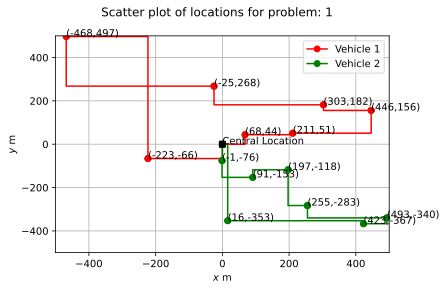

In [86]:
P1 = Problem(locations=locations, distances=distances, annotations=annotations)
P1.plot_locations()
P1.minimize(method="default")
edge_paths = P1.edge_paths()
node_paths = P1.node_paths()
plot_results(edge_paths, P1.locations)

## Conducting Problem Analysis

We want to solve a number of different problems to see how they scale and how the perfomance of the algorithm changes over time

### Performance while scaling the number of vehicles
Scaling the number of vehicles using the default [Branch and Cut Method](https://www.coin-or.org/Cbc/ch01s04.html) Method

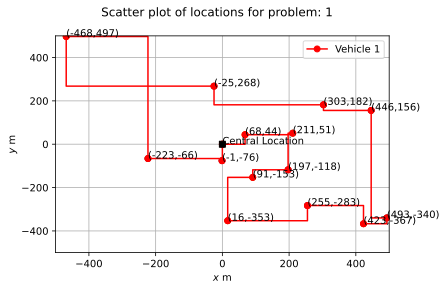

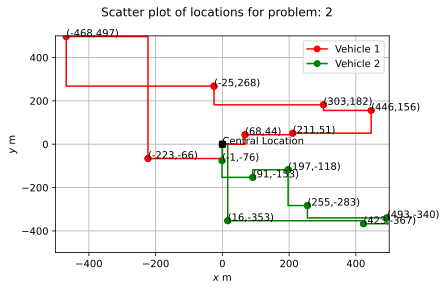

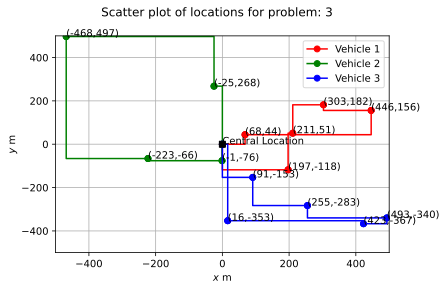

In [87]:
num_vehicles = [1, 2, 3]
locations, distances, annotations = generate_data(
    num_locations=NUM_LOCATIONS,
    grid_size=GRID_SIZE,
    seed=SEED,
    distance_method=DISTANCE_METHOD,
)

problems: list[Problem] = []
process_times: list[float] = []
process_cpu_times: list[float] = []

for idx, vehicles in enumerate(num_vehicles):
    problem = Problem(
        locations=locations,
        distances=distances,
        annotations=annotations,
        num_vehicles=vehicles,
        id=idx + 1,
    )
    problems.append(problem)

for problem in problems:
    problem.plot_locations()
    _, state = problem.minimize(method="default")
    process_times.append(state.solutionTime)
    process_cpu_times.append(state.solutionCpuTime)
    edge_paths = problem.edge_paths()
    node_paths = problem.node_paths()
    plot_results(edge_paths, problem.locations)

### Solution-Time Versus number of vehicles
We want to see how the number of vehicles relates to the runtime of the solution using the **Branch and Cut** Method

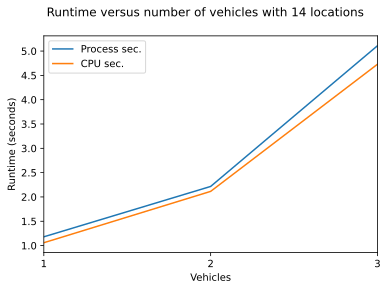

In [88]:
f = plt.figure()
ax = f.gca()
plt.suptitle(
    "Runtime versus number of vehicles with " + str(NUM_LOCATIONS) + " locations"
)
x = plt.plot(num_vehicles, process_times, label="Process sec.")
y = plt.plot(num_vehicles, process_cpu_times, label="CPU sec.")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("Vehicles")
plt.ylabel("Runtime (seconds)")
plt.legend(labels=[], handles=[x])
plt.xlim([num_vehicles[0], num_vehicles[len(num_vehicles) - 1]])
plt.show()

## Evaluating Performance with of $n$ locations and $k$ Vehicles

We want to see how performance changes with $n=[1,4,...,30], n_{n+1} = n+3$ locations and $k=[1,2,3], k_{k+1} = k+1$ vehicles.

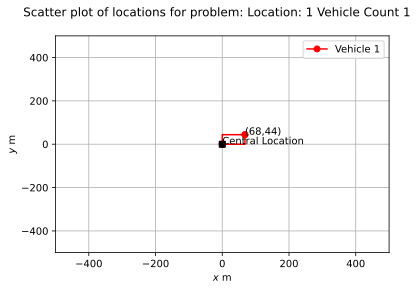

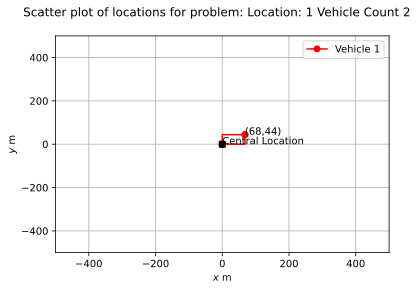

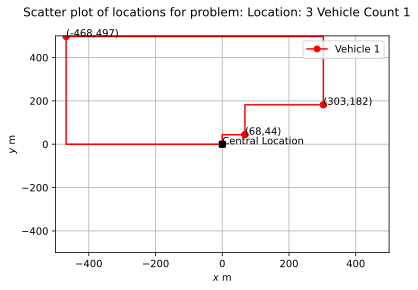

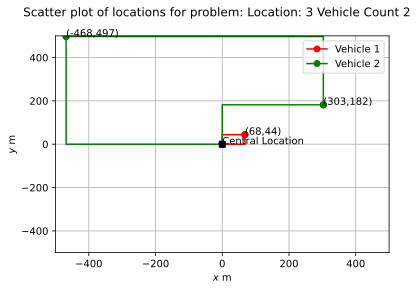

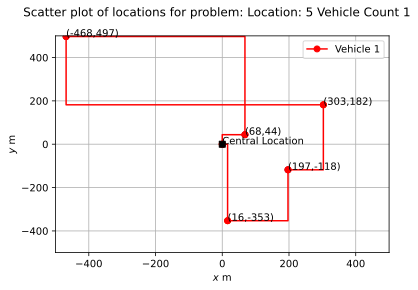

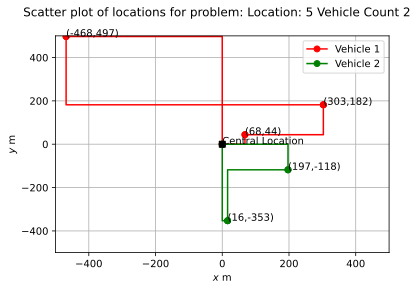

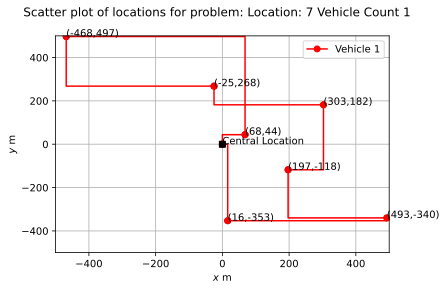

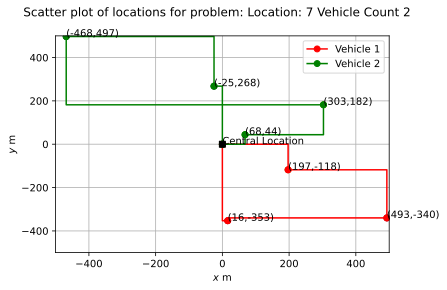

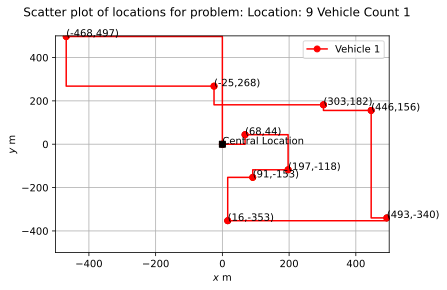

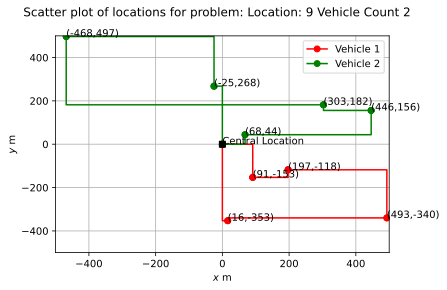

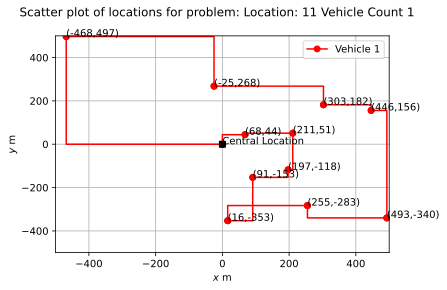

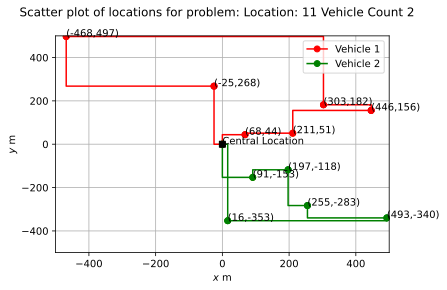

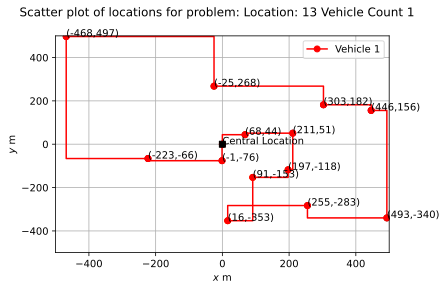

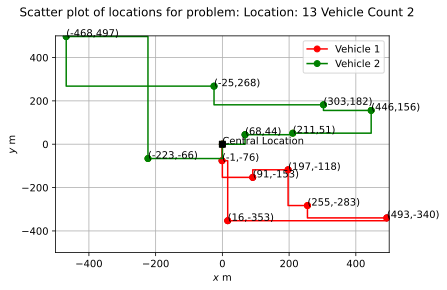

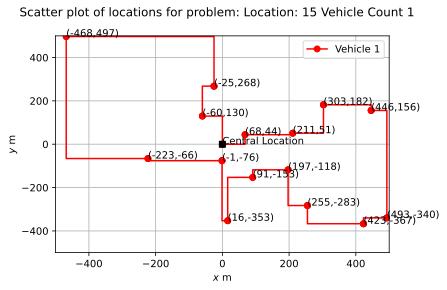

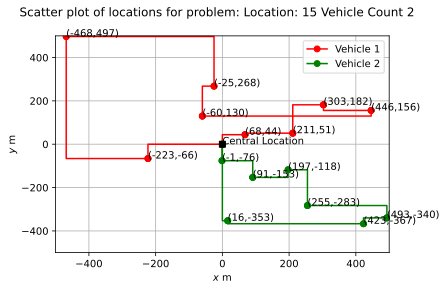

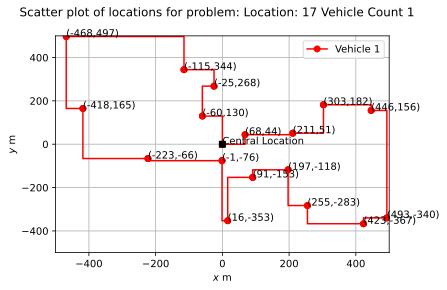

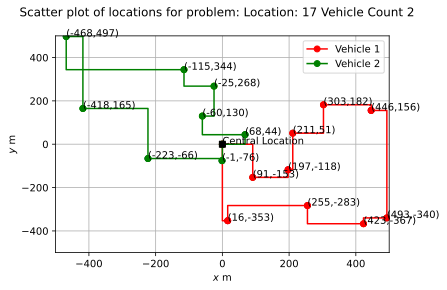

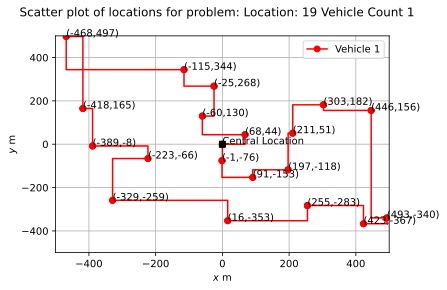

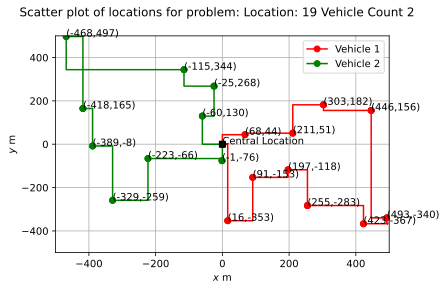

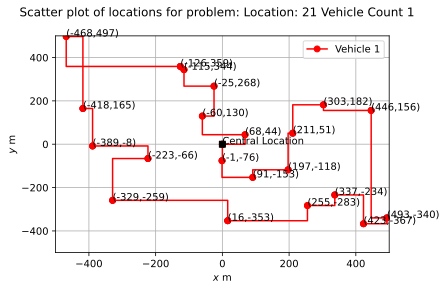

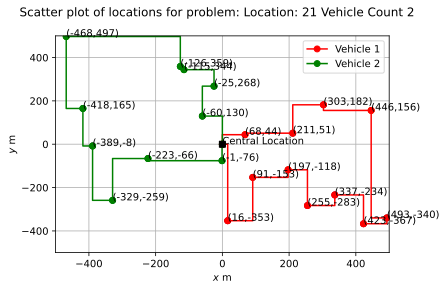

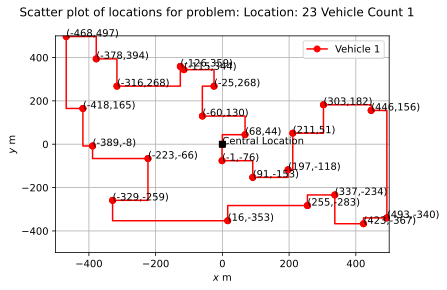

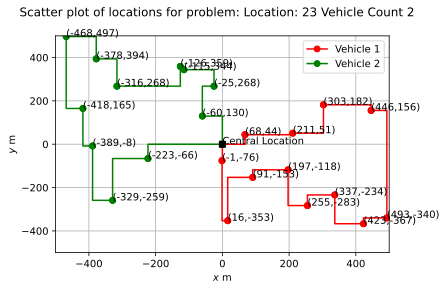

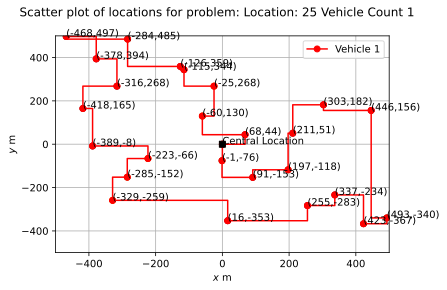

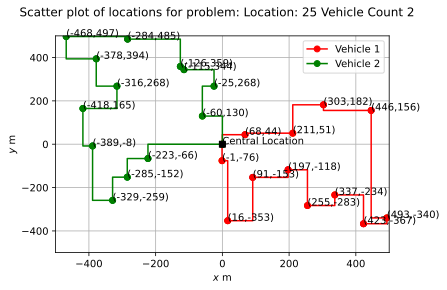

In [89]:
MIN_LOCATIONS = 1
MAX_LOCATIONS = 25
INC = 2

# create our data matrices
num_of_locations = np.arange(MIN_LOCATIONS, MAX_LOCATIONS + 1, INC)
num_vehicles: list[int] = [1, 2]
problems: list[list[Problem]] = []
process_times: list[list[float]] = []
process_cpu_times: list[list[float]] = []

### Create our problems
for location_count in num_of_locations:
    NUM_LOCATIONS = location_count
    locs, distances, annotations = generate_data(
        num_locations=NUM_LOCATIONS,
        grid_size=GRID_SIZE,
        seed=SEED,
        distance_method=DISTANCE_METHOD,
    )
    vehicle_problems: list[Problem] = []
    for jdx, vehicles in enumerate(num_vehicles):
        problem = Problem(
            num_locations=NUM_LOCATIONS,
            locations=locs,
            distances=distances,
            annotations=annotations,
            num_vehicles=vehicles,
            id="Location: " + str(location_count) + " Vehicle Count " + str(vehicles),
        )
        vehicle_problems.append(problem)
    problems.append(vehicle_problems)

### Solve our Problems
for locations_problems in problems:
    vehicle_process_times: list[float] = []
    vehicle_process_cpu_times: list[float] = []
    for vehicle_problem in locations_problems:
        vehicle_problem.plot_locations()
        _, state = vehicle_problem.minimize(method="default")
        vehicle_process_times.append(state.solutionTime)
        vehicle_process_cpu_times.append(state.solutionCpuTime)
        edge_paths = vehicle_problem.edge_paths()
        node_paths = vehicle_problem.node_paths()
        plot_results(edge_paths, problem.locations)
    process_times.append(vehicle_process_times)
    process_cpu_times.append(vehicle_process_cpu_times)

### Solution-Time Versus number of vehicles and number of locations
We want to see how the number of vehicles as well as locations relates to the runtime of the solution using the **Branch and Cut** Method

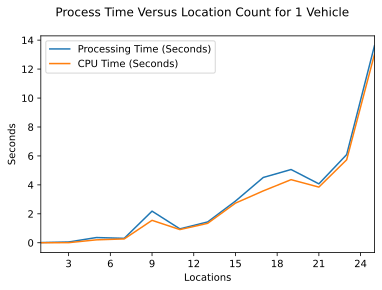

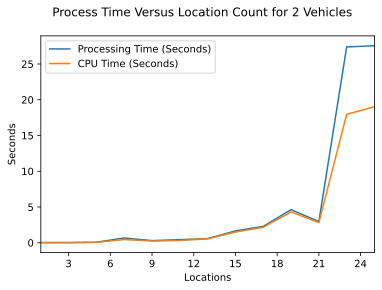

In [91]:
# transpose our matrices so that they are in terms of vehicles
process_times_transp = np.transpose(process_times)
process_cpu_times_transp = np.transpose(process_cpu_times)


f = plt.figure()
ax = f.gca()
plt.suptitle("Process Time Versus Location Count for 1 Vehicle")
x = plt.plot(
    num_of_locations, process_times_transp[1, :], label="Processing Time (Seconds)"
)
y = plt.plot(
    num_of_locations, process_cpu_times_transp[1, :], label="CPU Time (Seconds)"
)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(labels=[], handles=[x, y])
plt.xlabel("Locations")
plt.ylabel("Seconds")
plt.xlim([num_of_locations[0], num_of_locations[len(num_of_locations) - 1]])
plt.show()

f = plt.figure()
ax = f.gca()
plt.suptitle("Process Time Versus Location Count for 2 Vehicles")
x = plt.plot(
    num_of_locations, process_times_transp[0, :], label="Processing Time (Seconds)"
)
y = plt.plot(
    num_of_locations, process_cpu_times_transp[0, :], label="CPU Time (Seconds)"
)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(labels=[], handles=[x, y])
plt.xlabel("Locations")
plt.ylabel("Seconds")
plt.xlim([num_of_locations[0], num_of_locations[len(num_of_locations) - 1]])
plt.show()